## Problem Statement
- You will be provided with a data set about students. The data set includes
information about the students’ age, nationality, gender, as well as information
about their studying habits. There is also a binary column expressing whether or not
the students passed an important test.

#### Part 1: Analysis
- Describe the demographic details of people most likely to pass the test
- Describe the efficacy of the two interventions - the test prep course and the
Dojo class
- Identify any other interesting trends from the data set and offer some analysis
as to their importance or cause.


#### Part 2: Model Creation
- Create a model that can predict whether or not a student will pass the test. Use the
provided data set to train your model and test its accuracy. You have free choice of
programming language, algorithm, and tools.


#### Part 3: Reporting
The goal in the final stage is to communicate your findings to less technical
management staff. There are two requirements:
- Create visualizations to show the efficacy of your model. A non-data scientist
should be able to infer at a glance how well it fits the data.
- Offer ideas for how we might help more people pass the test and create more
accurate models based on your findings. Summarize with bullet points and
consider adding more visuals

In [1]:
# %%html
# <style>
# div.input {
#     display:none;
# }
# </style>

###  Data Cleaning and Preprocessing
- Handling missing values.
- Encoding categorical variables.
- Dealing with outliers.


#### Read the file

In [2]:
#Read the file
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


%matplotlib inline

df = pd.read_csv('test_data (1).tsv', sep='\t')

In [3]:
##5000 rows and 11 columns have been provided in the data.
df

,sex,lang,country,age,first,last,hours_studied,dojo_class,test_prep,pass,notes
0,Male,Japanese,Japan,20,Juurou,Hayashi,10.578594,True,False,True,NaN
1,Male,Japanese,Japan,22,Ryūji,Yamasaki,7.814520,False,False,True,NaN
2,Male,Japanese,Japan,27,Ryūnosuke,Inoue,4.213682,False,False,True,NaN
3,Male,Japanese,Japan,24,Shin,Kobayashi,NaN,False,False,True,NaN
4,Female,Japanese,Japan,21,Ran,Ono,3.248907,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,Japanese,Japan,29,Shirō,Watanabe,3.291721,False,False,True,NaN
4996,Female,Japanese,Japan,22,Aki,Kato,1.590491,False,False,False,NaN
4997,Male,English,UK,25,Ozzy,Haward,5.029988,False,False,False,NaN
4998,Male,Japanese,Japan,22,Sōma,Saitō,1.730570,True,False,True,NaN


In [4]:
#Good to see that age, hours_studied, are already numerical
df.dtypes

sex               object
lang              object
country           object
age                int64
first             object
last              object
hours_studied    float64
dojo_class          bool
test_prep           bool
pass                bool
notes             object
dtype: object

Seems like % of missing values **hours_studied** and **is_note** please too High. 

In [5]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
sex,0.00
lang,0.00
country,0.00
age,0.00
first,0.00
last,0.00
hours_studied,39.64
dojo_class,0.00
test_prep,0.00
pass,0.00


In [57]:
#Upon checking notes, it seems like it's gargbage. But, let's keep it to see if we find something with records that have notes.
# "". join(df[~df['notes'].isna()]['notes'])

In [7]:
#Make a new feature called is_note and fill it with zeros where notes is NaN amd drop notes
df['is_note'] = np.where(pd.isna(df['notes']), 0, 1)
df.drop(columns=['notes'], inplace=True)

In [8]:
df['dojo_class'] = df['dojo_class'].replace({True: 1, False: 0})
df['test_prep'] = df['test_prep'].replace({True: 1, False: 0})
df['pass'] = df['pass'].replace({True: 1, False: 0})

- Outliers are spotted in age and hours studied category.

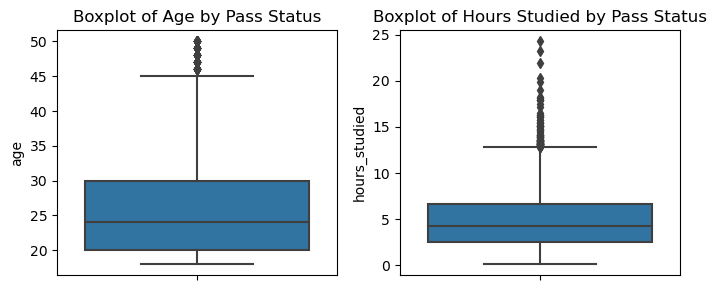

In [9]:
# Set up the matplotlib figure
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='age')
plt.title('Boxplot of Age by Pass Status')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='hours_studied')
plt.title('Boxplot of Hours Studied by Pass Status')

# Adjust layout to prevent overlap of titles
plt.tight_layout()

# Show plot
plt.show()

- Let's vizualise the distribution of these two features

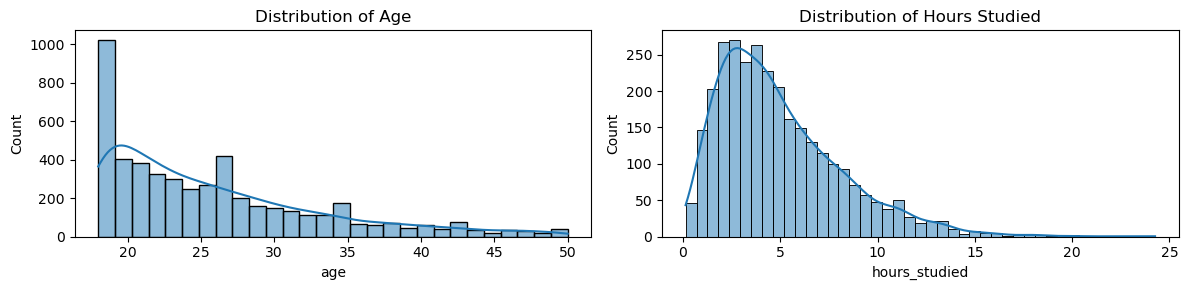

In [10]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Plot histogram for 'age'
sns.histplot(data=df, x='age', ax=axs[0], kde=True)
axs[0].set_title('Distribution of Age')

# Plot histogram for 'hours_studied'
sns.histplot(data=df, x='hours_studied', ax=axs[1], kde=True)
axs[1].set_title('Distribution of Hours Studied')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

- Let's impute the outliers

In [11]:
# Function to fill outliers with NaN and calculate the percentage of data imputed
def fill_outliers_with_nan(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_rows = (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
    dataframe.loc[outlier_rows, column] = np.nan
    
    imputed_count = np.sum(outlier_rows)
    percentage_imputed = (imputed_count / len(dataframe)) * 100
    print(f"Volume of data imputed with NaN for {column}: {imputed_count} ({percentage_imputed:.2f}%)")

# Fill outliers with NaN for the 'hours_studied' column and calculate the percentage imputed
fill_outliers_with_nan(df, 'hours_studied')

# Fill outliers with NaN for the 'age' column and calculate the percentage imputed
fill_outliers_with_nan(df, 'age')

Volume of data imputed with NaN for hours_studied: 80 (1.60%)
Volume of data imputed with NaN for age: 123 (2.46%)


- Impute the age with median.
- Due to the significant amount of missing data in the 'hours studied' column, we will use a different imputation technique. Specifically, we will impute the missing values by calculating the average hours studied for each age group within each country. This way, the imputed values will be more representative of the typical study habits of students in the same age group and country.

In [14]:
# Impute missing values of age with median
median_age = df['age'].median()
df['age'].fillna(median_age, inplace=True)

# Create a DataFrame with all combinations of ages (18 to 45) and countries
ages = np.arange(df.age.min(), df.age.max()+1)
countries = df['country'].unique()

# Calculate average hours_studied by age and country
avg_hours_studied_by_age_country = df.groupby(['age', 'country']).agg({'hours_studied': 'mean'}).reset_index()

all_combinations = pd.MultiIndex.from_product([ages, countries], names=['age', 'country']).to_frame(index=False)

# Merge the grouped DataFrame with the all_combinations DataFrame
merged_df = all_combinations.merge(avg_hours_studied_by_age_country, on=['age', 'country'], how='left')

# Calculate the average hours studied for each age group across all countries
age_avg_hours = df.groupby('age')['hours_studied'].mean().reset_index()

# Merge and impute missing values
merged_df = pd.merge(merged_df, age_avg_hours, on='age', how='left', suffixes=('_orig', '_avg'))
merged_df['hours_studied'] = merged_df['hours_studied_orig'].fillna(merged_df['hours_studied_avg'])

# # Drop the extra columns if needed
merged_df = merged_df.drop(columns=['hours_studied_orig', 'hours_studied_avg'])
# Merge based on 'country' and 'age'
merged_df = pd.merge(df, merged_df, on=['country', 'age'], how='left', suffixes=('_df', '_merged'))

# Update 'hours_studied_df' with non-null values from 'hours_studied_merged'
merged_df['hours_studied_df'] = merged_df['hours_studied_merged'].fillna(merged_df['hours_studied_df'])
merged_df = merged_df.drop(columns=['hours_studied_merged'])

In [16]:
merged_df.rename(columns={'hours_studied_df':'hours_studied'}, inplace=True)
df= merged_df.copy()

- The ditribution of age remains same.
- The distibution of hours_studied looks same without outliers. More values have been addded to middle ranges of hours_studied.

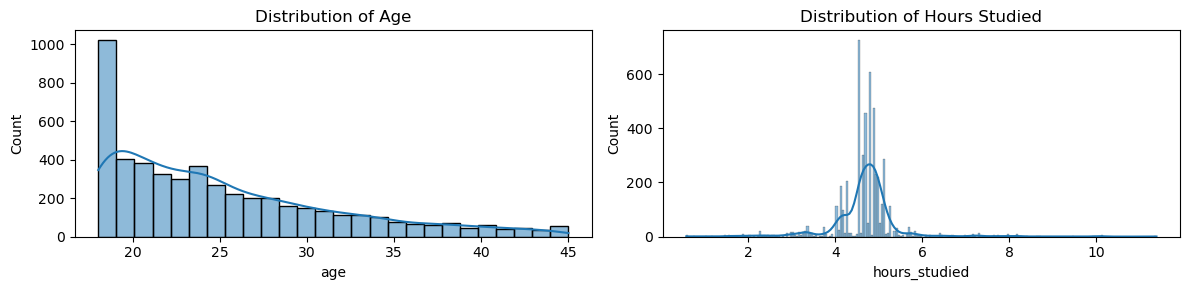

In [17]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Plot histogram for 'age'
sns.histplot(data=df, x='age', ax=axs[0], kde=True)
axs[0].set_title('Distribution of Age')

# Plot histogram for 'hours_studied'
sns.histplot(data=df, x='hours_studied', ax=axs[1], kde=True)
axs[1].set_title('Distribution of Hours Studied')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### EDA

- Majority (53%) of the students have failed the exam
- Most spoken language is Japanese.

In [18]:
df.country.value_counts()

Japan          4022
Italy           145
USA             140
Australia       134
New Zealand     131
France          128
UK              123
Mexico           73
Spain            59
Finland          45
Name: country, dtype: int64

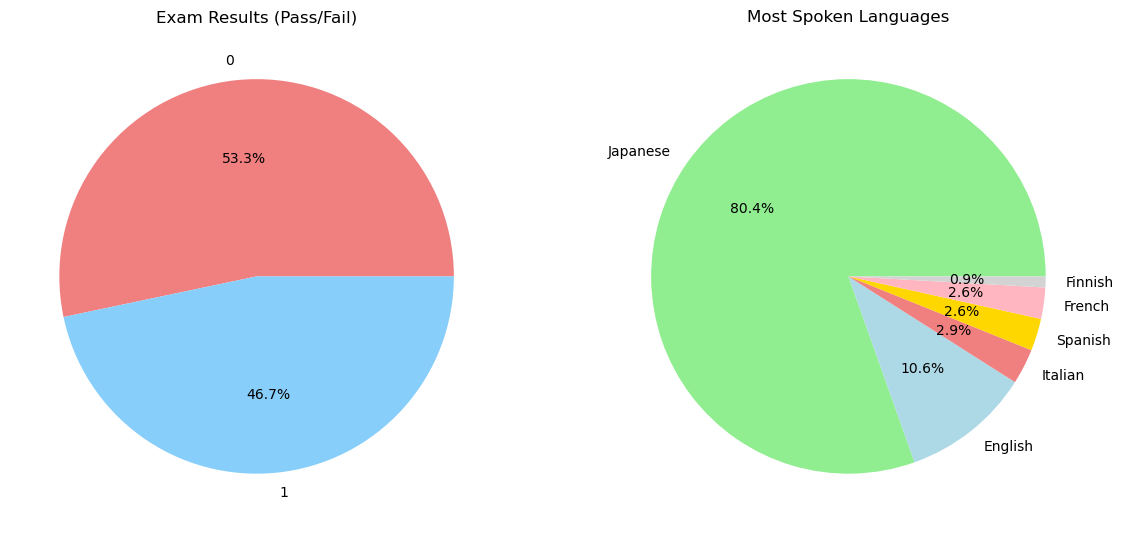

In [19]:
# Calculating the value counts and their proportions
pass_counts = df['pass'].value_counts(normalize=True)
lang_counts = df['lang'].value_counts(normalize=True)

# Creating pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for pass/fail
ax1.pie(pass_counts, labels=pass_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
ax1.set_title('Exam Results (Pass/Fail)')

# Pie chart for languages
ax2.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'lightcoral', 'gold', 'lightpink', 'lightgrey'])
ax2.set_title('Most Spoken Languages')

plt.show()

- More males have passed the exam exam, whereas more females have failed exam.
- % of the people who have taken the DOJO class and test prep have higher passing percentage.


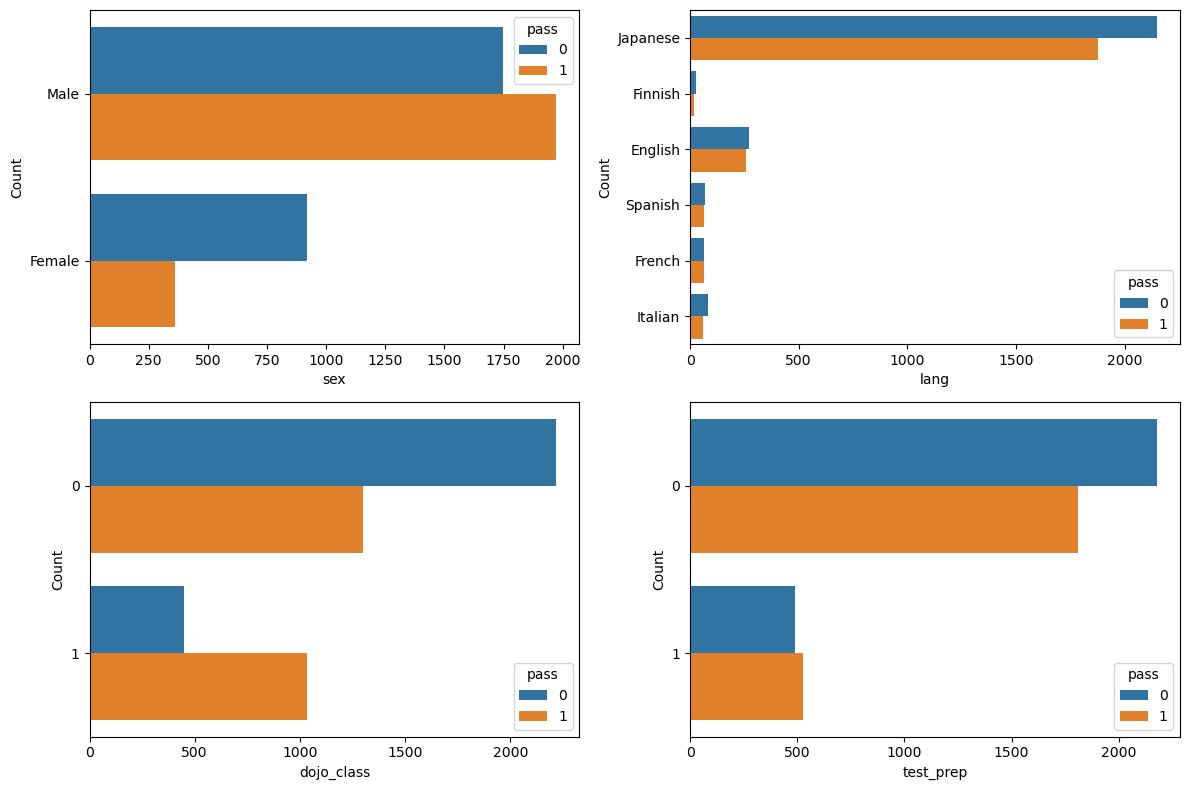

In [20]:
import seaborn as sns

num_rows = 2
num_cols = 2

# Create a figure and subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each column and draw a countplot
for i, col in enumerate(df[['sex', 'lang',
       'dojo_class', 'test_prep']].columns):
    ax = axes[i]
    sns.countplot(data=df, y=col, hue='pass', ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

- % of people under 35 have passed more in exam is high, as compared to middle aged and those above 35.
- % of people who have studied upto 6 hours have passed more in exam as compared to those who have studies for more than 6 hours.

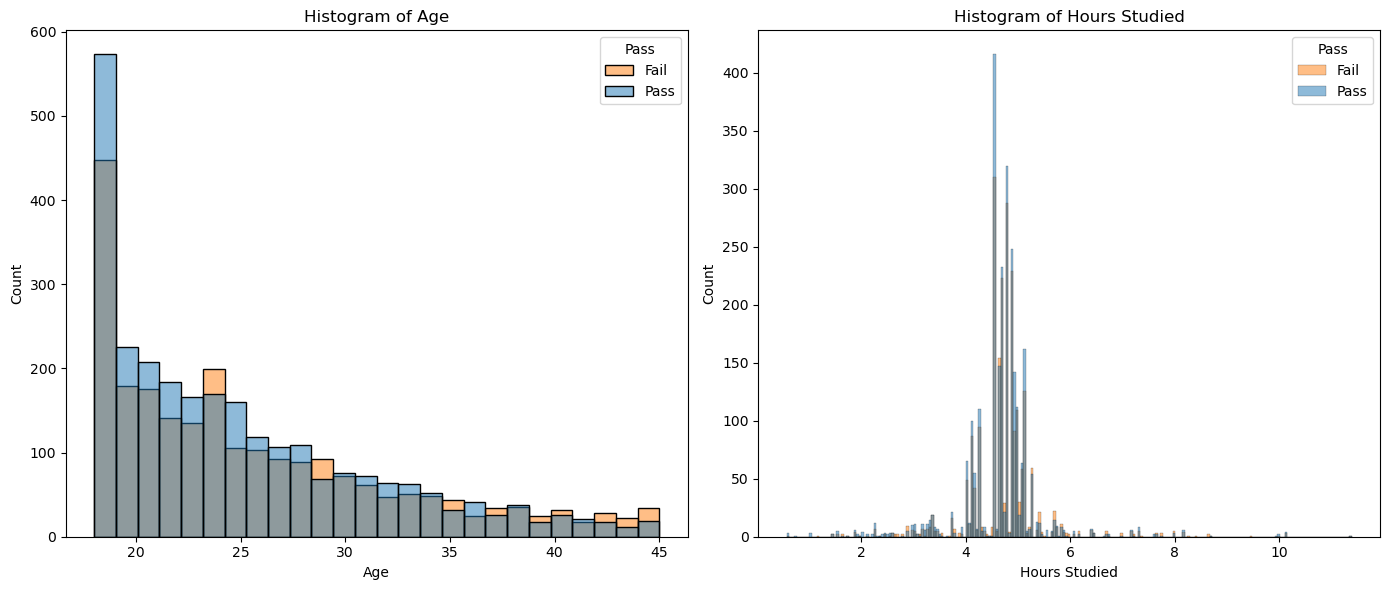

In [21]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 'age' variable
sns.histplot(data=df, x='age', hue='pass', ax=ax1)
ax1.set_title('Histogram of Age')

# Plot for 'hours_studied' variable
sns.histplot(data=df, x='hours_studied', hue='pass', ax=ax2)
ax2.set_title('Histogram of Hours Studied')

# Adjusting legend and labels
ax1.legend(title='Pass', labels=['Fail', 'Pass'])
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

ax2.legend(title='Pass', labels=['Fail', 'Pass'])
ax2.set_xlabel('Hours Studied')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

- Young students from Italy seems to be studying for longer hours, where as middle aged students from USA study for long hours.

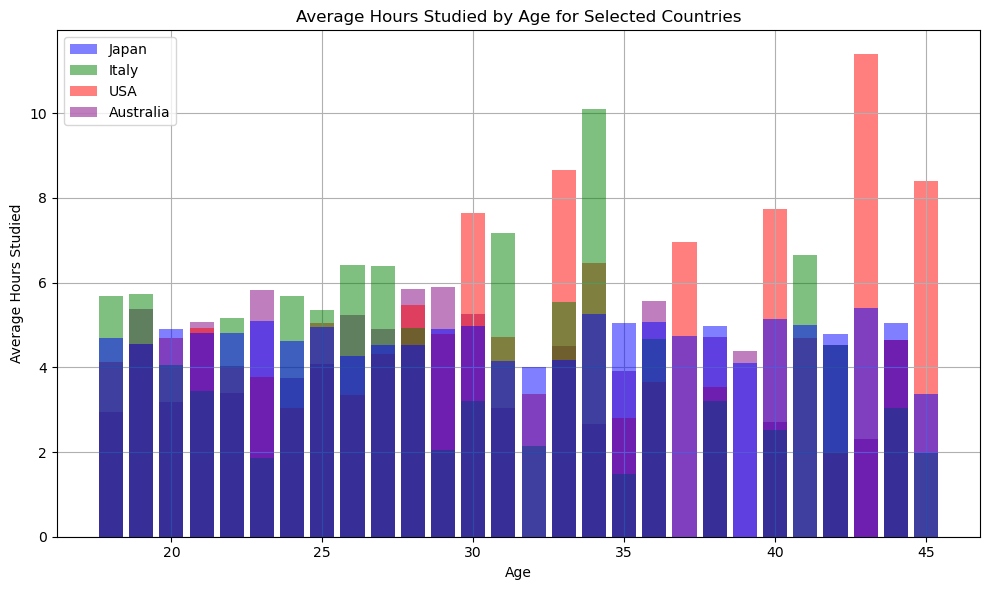

In [22]:
# Calculate average hours studied by age and country
avg_hours_studied = df.groupby(['age', 'country'])['hours_studied'].mean().reset_index()

# Filter the data for the specified countries
countries_of_interest = ['Japan', 'Italy', 'USA', 'Australia']
filtered_df = avg_hours_studied[avg_hours_studied['country'].isin(countries_of_interest)]

# Pivot the data to prepare for plotting
pivot_df = filtered_df.pivot(index='age', columns='country', values='hours_studied')

# Plotting with transparent and overlapping bars
plt.figure(figsize=(10, 6))

# Define colors and transparency
colors = {'Japan': 'blue', 'Italy': 'green', 'USA': 'red', 'Australia': 'purple'}
alphas = [0.5, 0.5, 0.5, 0.5]  # Adjust transparency here

for i, country in enumerate(countries_of_interest):
    plt.bar(pivot_df.index, pivot_df[country], label=country, color=colors[country], alpha=alphas[i], zorder=3-i)

plt.xlabel('Age')
plt.ylabel('Average Hours Studied')
plt.title('Average Hours Studied by Age for Selected Countries')
plt.legend()
plt.grid(True)

# Ensure bars overlap properly
plt.tight_layout()
plt.show()

Describe the demographic details of people most likely to pass the test
- Men are

### Feature Selection and Engineering

- Sex seems appears to be significate and null hypothesis is rejected for these variable. However, language, and country are not significant.
- Different age categories and hours_studied_category significantly influence the likelihood of 'pass' or 'fail'.

In [23]:
from scipy import stats

demographic_variables = ['sex', 'lang', 'country']
numerical_variables = ['age', 'hours_studied']

# Iterate over the demographic variables
for variable in demographic_variables:
    # Perform chi-square test to assess the association between the demographic variable and 'pass' variable
    cross_tab = pd.crosstab(df[variable], df['pass'])
    chi2, p_value, _, _ = stats.chi2_contingency(cross_tab)
    print(f"Demographic Variable: {variable}")
    print(f"Chi-square test statistic: {chi2}")
    print(f"P-value: {p_value}")
    print()

#Binning 'age' into categories and performing chi-square test
df['age_category'] = pd.cut(df['age'], bins=[0, 20, 30, 40, 50], labels=['0-20', '21-30', '31-40', '41-50'])
contingency_table_age = pd.crosstab(df['age_category'], df['pass'])
chi2_stat_age, p_val_age, dof_age, expected_age = stats.chi2_contingency(contingency_table_age)
print(f"Chi-square statistic for age_category: {chi2_stat_age}")
print(f"P-value for age_category: {p_val_age}")
print(f"Degrees of Freedom for age_category: {dof_age}")
print("Expected frequencies:")
print(expected_age)
print()

# Calculate quartiles
quartiles = pd.qcut(df['hours_studied'], q=4, retbins=True, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df['hours_studied_category'] = quartiles[0]
bins = quartiles[1]

# Display ranges for each quartile
for i in range(4):
    print(f"Range for Q{i+1}: {bins[i]} to {bins[i+1]}")

# Create contingency table
contingency_table_hours = pd.crosstab(df['hours_studied_category'], df['pass'])

# Perform chi-square test
chi2_stat_hours, p_val_hours, dof_hours, expected_hours = stats.chi2_contingency(contingency_table_hours)

# Display results
print(f"Chi-square statistic for hours_studied_category: {chi2_stat_hours}")
print(f"P-value for hours_studied_category: {p_val_hours}")
print(f"Degrees of Freedom for hours_studied_category: {dof_hours}")
print("Expected frequencies:")
print(expected_hours)


Demographic Variable: sex
Chi-square test statistic: 232.31470630588373
P-value: 1.8644660635947317e-52

Demographic Variable: lang
Chi-square test statistic: 3.8561009764322165
P-value: 0.5703144804818312

Demographic Variable: country
Chi-square test statistic: 5.116298839504643
P-value: 0.8240545914100535

Chi-square statistic for age_category: 17.205912201541643
P-value for age_category: 0.0006410618513075129
Degrees of Freedom for age_category: 3
Expected frequencies:
[[ 758.992  665.008]
 [1371.409 1201.591]
 [ 443.989  389.011]
 [  90.61    79.39 ]]

Range for Q1: 0.5712071422614288 to 4.534112447147386
Range for Q2: 4.534112447147386 to 4.6991423335716584
Range for Q3: 4.6991423335716584 to 4.942979761030692
Range for Q4: 4.942979761030692 to 11.386540531026585
Chi-square statistic for hours_studied_category: 4.853949940202781
P-value for hours_studied_category: 0.18280940054953143
Degrees of Freedom for hours_studied_category: 3
Expected frequencies:
[[719.017 629.983]
 [616.6

### Describe the efficacy of the two interventions - the test prep course and the Dojo class

- Both the test prep course and the Dojo class have a significant impact on students' pass rates
- There doesn't seems to be significant strong co-relation between the hours studies and passing the exam.

Pass rates based on Test Prep:
test_prep
0    0.453838
1    0.518738
Name: pass, dtype: float64
51% of those who took the test passed, compared to 45% of those who did not take the test prep.

Pass rates based on Dojo Class:
dojo_class
0    0.369528
1    0.698381
Name: pass, dtype: float64
70% of those who took the test passed, compared to 40% of those who did not take the Dojo Class.

Chi-square test results:
Test Prep: Chi2 = 13.419068892254954, p-value = 0.0002490793016899712
Dojo Class: Chi2 = 451.7150999910964, p-value = 3.053964098501853e-100
Relationship between hours studied and being passed.

Correlation with Pass:
Pearson Correlation: 0.03862673098946731
Spearman Correlation: 0.029150898863338555


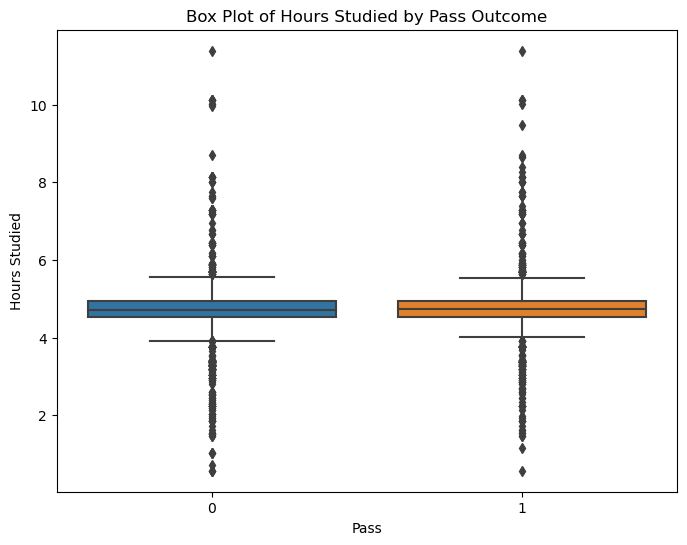

In [25]:
from scipy.stats import chi2_contingency, spearmanr

# Calculate pass rates for students who took the test prep vs. those who didn't
test_prep_pass_rates = df.groupby('test_prep')['pass'].mean()
print("Pass rates based on Test Prep:")
print(test_prep_pass_rates)
print('51% of those who took the test passed, compared to 45% of those who did not take the test prep.')

# Calculate pass rates for students who attended the Dojo class vs. those who didn't
dojo_class_pass_rates = df.groupby('dojo_class')['pass'].mean()
print("\nPass rates based on Dojo Class:")
print(dojo_class_pass_rates)
print('70% of those who took the test passed, compared to 40% of those who did not take the Dojo Class.')

# Conduct chi-square test for independence to determine if test_prep and dojo_class impact passing rates
chi2_test_prep, p_test_prep, _, _ = chi2_contingency(pd.crosstab(df['test_prep'], df['pass']))
chi2_dojo_class, p_dojo_class, _, _ = chi2_contingency(pd.crosstab(df['dojo_class'], df['pass']))

print("\nChi-square test results:")
print(f"Test Prep: Chi2 = {chi2_test_prep}, p-value = {p_test_prep}")
print(f"Dojo Class: Chi2 = {chi2_dojo_class}, p-value = {p_dojo_class}")

print('Relationship between hours studied and being passed.')
pearson_corr = df[['pass', 'hours_studied']].corr().iloc[0, 1]
spearman_corr, _ = spearmanr(df['pass'], df['hours_studied'])

print("\nCorrelation with Pass:")
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

# Visualization
plt.figure(figsize=(8, 6))
sns.boxplot(x='pass', y='hours_studied', data=df)
plt.title('Box Plot of Hours Studied by Pass Outcome')
plt.xlabel('Pass')
plt.ylabel('Hours Studied')
plt.show()

### Feature Engineering and Modelling
- Logistic Regression and Random Forest models.
- Evaluation of models using accuracy, confusion matrices, ROC curves, and precision-recall curves.

In [28]:
contingency_table = pd.crosstab(df['lang'], df['country'])

In [29]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")


Chi-square statistic: 25000.0
P-value: 0.0


Let's remove the Language as it is strongly realated to the country. 

In [30]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_value = cramers_v(contingency_table)

print(f"Cramér's V: {cramers_v_value}")



Cramér's V: 0.9995994391988303


In [31]:
df.drop(columns=['age','lang','is_note','hours_studied','first', 'last'], inplace=True)

In [32]:
df

,sex,country,dojo_class,test_prep,pass,age_category,hours_studied_category
0,Male,Japan,1,0,1,0-20,Q3
1,Male,Japan,0,0,1,21-30,Q3
2,Male,Japan,0,0,1,21-30,Q1
3,Male,Japan,0,0,1,21-30,Q2
4,Female,Japan,0,0,0,21-30,Q3
...,...,...,...,...,...,...,...
4995,Male,Japan,0,0,1,21-30,Q3
4996,Female,Japan,0,0,0,21-30,Q3
4997,Male,UK,0,0,0,21-30,Q1
4998,Male,Japan,1,0,1,21-30,Q3


- Label Encoding: Apply LabelEncoder to sex, age_category, and hours_studied_category since these variables have an ordinal relationship

- One-Hot Encoding: Use OneHotEncoder for country since it does not have a natural order

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Separate features (X) and target variable (y)
X = df.drop('pass', axis=1)
y = df['pass']

# Perform label encoding on sex, age_category, and hours_studied_category
label_encoders = {}
for col in ['sex', 'age_category', 'hours_studied_category']:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Perform one-hot encoding on country
X = pd.get_dummies(X, columns=['country'], drop_first=True)  # drop_first=True to avoid multicollinearity

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
logistic_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Train models
logistic_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_logistic = logistic_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate accuracy
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'Logistic Regression Accuracy: {accuracy_logistic:.4f}')
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')


Logistic Regression Accuracy: 0.6270
Random Forest Accuracy: 0.6660


### Efficacy of model

In [65]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
) 

# Calculate KPIs for Logistic Regression
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)

# Calculate KPIs for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print KPIs
print(f'Logistic Regression Accuracy: {accuracy_logistic:.4f}')
print(f'Logistic Regression Precision: {precision_logistic:.4f}')
print(f'Logistic Regression Recall: {recall_logistic:.4f}')
print(f'Logistic Regression F1-Score: {f1_logistic:.4f}')
print(f'Logistic Regression ROC-AUC: {roc_auc_logistic:.4f}')
print(f'Logistic Regression Confusion Matrix:\n{conf_matrix_logistic}')

print(f'Random Forest Accuracy: {accuracy_rf:.4f}')
print(f'Random Forest Precision: {precision_rf:.4f}')
print(f'Random Forest Recall: {recall_rf:.4f}')
print(f'Random Forest F1-Score: {f1_rf:.4f}')
print(f'Random Forest ROC-AUC: {roc_auc_rf:.4f}')
print(f'Random Forest Confusion Matrix:\n{conf_matrix_rf}')

# Classification Reports
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logistic))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Plot ROC curves
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

Logistic Regression Accuracy: 0.6270
Logistic Regression Precision: 0.6820
Logistic Regression Recall: 0.4533
Logistic Regression F1-Score: 0.5446
Logistic Regression ROC-AUC: 0.7059
Logistic Regression Confusion Matrix:
[[404 104]
 [269 223]]
Random Forest Accuracy: 0.6660
Random Forest Precision: 0.7147
Random Forest Recall: 0.5346
Random Forest F1-Score: 0.6116
Random Forest ROC-AUC: 0.7132
Random Forest Confusion Matrix:
[[403 105]
 [229 263]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.80      0.68       508
           1       0.68      0.45      0.54       492

    accuracy                           0.63      1000
   macro avg       0.64      0.62      0.61      1000
weighted avg       0.64      0.63      0.62      1000


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       508
           1       0.7

#### Vizualize

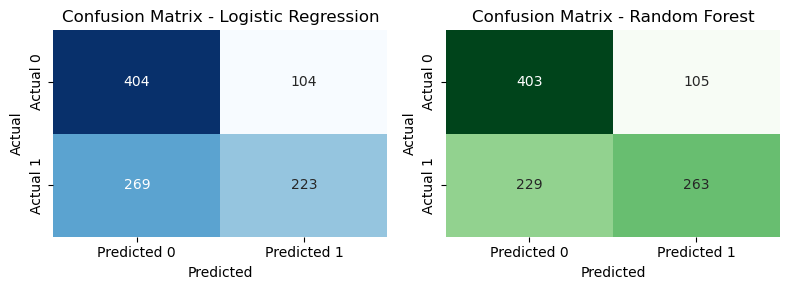

In [41]:
# Compute confusion matrices
cm_logreg = confusion_matrix(y_test, y_pred_logistic)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plotting both confusion matrices in a single figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Plotting confusion matrix for Logistic Regression
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix - Logistic Regression')

# Plotting confusion matrix for Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix - Random Forest')

plt.tight_layout()
plt.show()

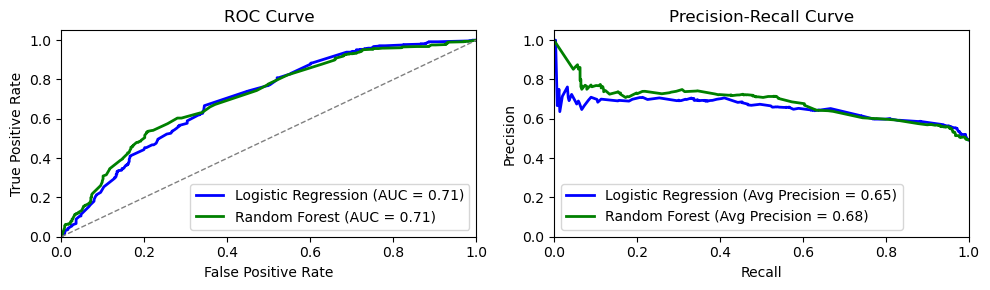

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
roc_auc_logreg = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calculate precision-recall curve and average precision for each model
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
avg_precision_logreg = average_precision_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
avg_precision_rf = average_precision_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Plotting both ROC and Precision-Recall curves in subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# ROC Curve subplot
axes[0].plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logreg)
axes[0].plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Precision-Recall Curve subplot
axes[1].plot(recall_logreg, precision_logreg, color='blue', lw=2, label='Logistic Regression (Avg Precision = %0.2f)' % avg_precision_logreg)
axes[1].plot(recall_rf, precision_rf, color='green', lw=2, label='Random Forest (Avg Precision = %0.2f)' % avg_precision_rf)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlim([0.0, 1.0])

plt.tight_layout()
plt.show()

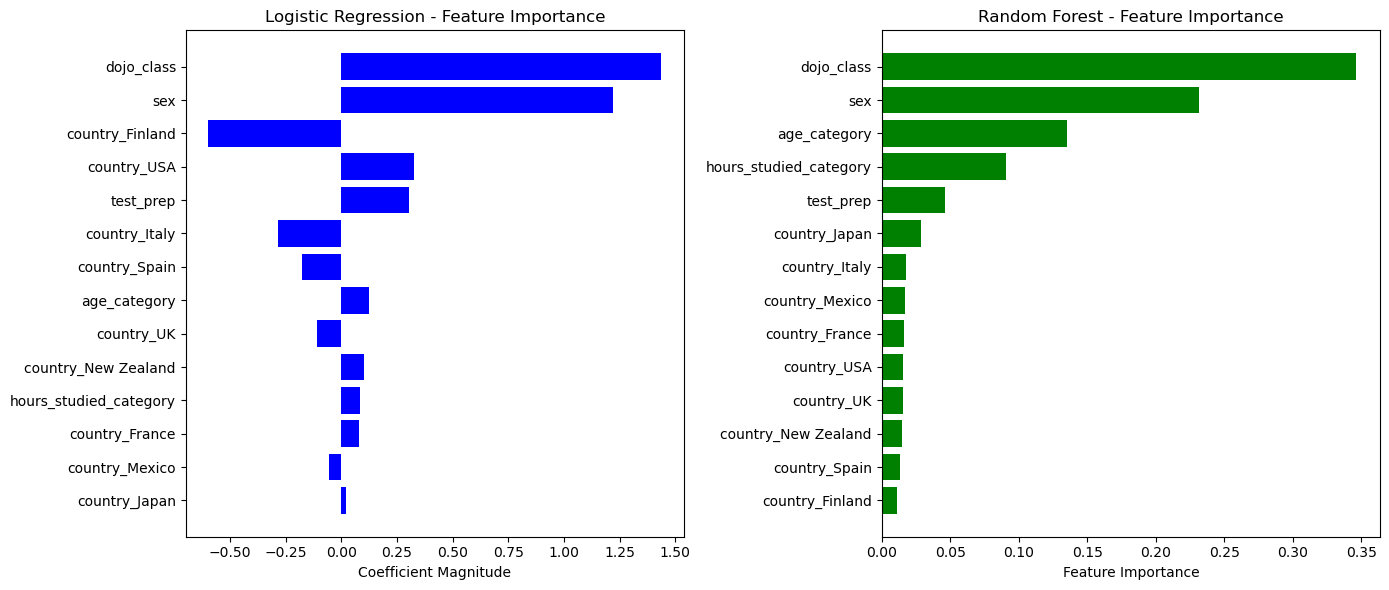

In [52]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = X.columns  # Get feature names

# Get coefficients from Logistic Regression model
coefficients = logistic_model.coef_[0]

# Sort feature importance based on absolute coefficient values for Logistic Regression
sorted_indices_lr = np.argsort(np.abs(coefficients))

# Get feature importances from Random Forest model
importances_rf = rf_model.feature_importances_

# Sort feature importance for Random Forest
sorted_indices_rf = np.argsort(importances_rf)

# Plotting both feature importance plots in subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Logistic Regression feature importance
axes[0].barh(range(len(sorted_indices_lr)), coefficients[sorted_indices_lr], align='center', color='blue')
axes[0].set_yticks(range(len(sorted_indices_lr)))
axes[0].set_yticklabels(np.array(feature_names)[sorted_indices_lr])
axes[0].set_xlabel('Coefficient Magnitude')
axes[0].set_title('Logistic Regression - Feature Importance')

# Plotting Random Forest feature importance
axes[1].barh(range(len(sorted_indices_rf)), importances_rf[sorted_indices_rf], align='center', color='green')
axes[1].set_yticks(range(len(sorted_indices_rf)))
axes[1].set_yticklabels(np.array(feature_names)[sorted_indices_rf])
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Random Forest - Feature Importance')

plt.tight_layout()
plt.show()


##### Logistic Regression: 
- Hours studied and participation in test prep or Dojo classes are important indicators. Positive values indicate features that increase the chances of passing, while negative values decrease the chances.

#####  Random Forest: 
- Higher values mean the feature is more important. For example, hours studied and test prep participation are top contributors to a student's success.


In [64]:
df['pass'].value_counts()

0    2665
1    2335
Name: pass, dtype: int64




### Conclusion:
- Model Preference: The Random Forest model performs better than the Logistic Regression model across most metrics, especially in terms of recall and F1-score for the positive class (students who passed). This makes Random Forest a better choice for this task.
- Recall Improvement: The recall for both models is relatively low, particularly for Logistic Regression. Since recall is crucial in this context (we want to correctly identify as many students who passed as possible), Random Forest's higher recall is advantageous.
- Hypertuning and Feature Engineering may further increase the performance

### Recommendations:
1. Encourage students to enroll in the dojo class
2. Conduct a detailed study to understand why gender is a significant factor. Analyze classroom dynamics, teacher interactions, and societal factors. 
3. Tailor educational approaches to suit different age groups.
4. Create a conducive study environment and encourage students to study for longer periods.
5. Promote test preparation programs and provide additional resources for test prep.
5. Investigate any significant educational practices or cultural aspects from countries with higher importance scores that might be beneficial if adopted. Explore the reasons behind this negative association with Finland.